## Assignment 01 - Multiclass Logistic Regression Classifier using Numpy

#### Team

1. Sheikh Mastura Farzana
2. Dhruvan Ganesh


In [1]:
import random
import struct

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

random.seed(1)
np.random.seed(1)


### 1. Utilities

In [2]:
def read_idx(filename):
    with open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


def assertShape(actual, expected):
    actual = np.shape(actual)
    expected = np.shape(expected)
    assert actual == expected, f"Shape Mismatch: expected {actual} to equal {expected}"


def plotLines(arr: [], arr2: [], title="", labels=[]):
    plt.plot(np.squeeze([range(1, len(arr) + 1)]), np.squeeze(arr), label=labels[0])
    plt.plot(np.squeeze([range(1, len(arr2) + 1)]), np.squeeze(arr2), label=labels[1])
    plt.title(title)
    plt.legend()
    plt.show()

### 2. Network Components

In [3]:
# Layer Base Class
class Layer(object):
    """
    Base class for Network Layers
    """
    def __init__(self):
        self._top_layer = False

    def build(self, input_shape, lr, batch_size):
        self._learning_rate = lr
        self._batch_size = batch_size
        return input_shape

    def forward(self, X):
        raise Exception("WARNING: Invoked unimplemented base class method!")

    def backward(self, grad, y):
        raise Exception("WARNING: Invoked unimplemented base class method!")


class Dense(Layer):
    def __init__(self, neurons: int):
        super().__init__()
        self._hidden = neurons

    def __str__(self):
        return f"""Dense ( Neurons: {self._hidden} )"""

    def build(self, input_shape, lr, batch_size):
        super().build(input_shape, lr, batch_size)

        self._weights = np.random.normal(size=(input_shape[1], self._hidden))
        self._bias = np.zeros(shape=(1, self._hidden))

        # expected output shape
        return np.shape(self.forward(np.zeros(shape=input_shape)))

    def forward(self, X):
        self._X = X
        return np.dot(self._X, self._weights) + self._bias

    def backward(self, grad, y):
        self._dw = (1 / self._batch_size) * np.dot(self._X.T, grad)
        self._db = (1 / self._batch_size) * np.sum(grad, axis=0, keepdims=True)

        if not self._top_layer:
            self._dX = np.dot(grad, self._weights.T)

        assertShape(self._dw, self._weights)
        assertShape(self._db, self._bias)

        # gradient update
        self._weights = self._weights - self._learning_rate * self._dw
        self._bias = self._bias - self._learning_rate * self._db

        if not self._top_layer:
            return self._dX


class ReLU(Layer):
    def forward(self, X):
        self.X = X
        X = np.copy(self.X)

        X[X < 0] = 0
        return X

    def backward(self, grad, y):
        return grad * (self.X >= 0)

    def __str__(self):
        return "ReLU()"


class Softmax(Layer):
    def forward(self, X):
        self.X = X
        _exp = np.exp(X - np.max(X, axis=1, keepdims=True))
        return _exp / _exp.sum(axis=1, keepdims=True)

    def backward(self, grad, y):
        _grad = np.copy(grad)
        _grad[range(self._batch_size), y.argmax(axis=1)] -= (1.0 / self._batch_size)
        return _grad

    def __str__(self):
        return "Softmax()"


class Loss(object):
    """
    Base class for Loss functions
    """

    def calculate(self, y_actual, y_predicted):
        raise Exception("WARNING: Invoked unimplemented base class method!")

    def gradient(self, y_actual, y_predicted):
        raise Exception("WARNING: Invoked unimplemented base class method!")


class MeanSquareErrorLoss(Loss):
    def __str__(self):
        return f"""MeanSquareErrorLoss()"""

    def calculate(self, y_actual, y_predicted):
        return np.mean((y_predicted - y_actual) ** 2, axis=1)

    def gradient(self, y_actual, y_predicted):
        return 2 * (y_predicted - y_actual)


class Network:
    """
    The Neural Network (or Model) class,
    which make uses of Layers, Loss functions
    """

    def __init__(self, layers: [Layer], loss_function: Loss):
        self._loss = loss_function
        self._layers = layers
        self._built = False

    def __str__(self):
        layers = "\n".join([str(layer) for layer in self._layers])
        return f"""Network(\nLayers: \n{layers}, \nLossFunction: {self._loss})\n"""

    def forward(self, batchX):
        feed_forward = batchX
        for layer in self._layers:
            feed_forward = layer.forward(feed_forward)
        return feed_forward

    def backward(self, batchY, feed_forward):
        grads = self._loss.gradient(batchY, feed_forward)
        _backpass_layers = reversed(self._layers)

        # # skipping last layer
        # next(_backpass_layers)

        for layer in _backpass_layers:
            grads = layer.backward(grads, batchY)

    def fit(self, X, y, batch_size=500, epochs=100, lr=0.003, testX=None, testY=None):
        self._X = X
        self._y = y
        self._batch_size = batch_size
        self.train_accuracy = []
        self.train_loss = []
        self.test_accuracy = []
        self.test_loss = []

        if not self._built:
            input_shape = np.shape(self._X)
            for layer in self._layers:
                input_shape = layer.build(
                    input_shape=input_shape, lr=lr, batch_size=batch_size
                )
            self._built = True

        # Print Network Configuration
        print(str(self))

        for epoch in range(1, epochs + 1):
            for batch_start in range(0, len(self._X), self._batch_size):
                batch_end = batch_start + batch_size

                batchX = self._X[batch_start:batch_end]
                batchY = self._y[batch_start:batch_end]

                feed_forward = self.forward(batchX)
                self.backward(batchY, feed_forward)

            self.train_accuracy.append(self.accuracy(X, y))
            self.train_loss.append(self.mse_loss(X, y))

            if testX is not None and testY is not None:
                self.test_accuracy.append(self.accuracy(testX, testY))
                self.test_loss.append(self.mse_loss(testX, testY))

            if epoch % (epochs // 10) == 0:
                print(f"Accuracy at epoch {epoch}:\t{self.train_accuracy[-1]}")
                print(f"MSE Loss at epoch {epoch}:\t{self.train_loss[-1]}")

            self._X, self._y = shuffle(self._X, self._y)

    def predict(self, X, softmax_scores=False):
        feed_forward = self.forward(X)

        if softmax_scores:
            return feed_forward

        return np.argmax(feed_forward, axis=1)

    def accuracy(self, X, y):
        predicted_label = self.predict(X)
        actual_label = np.argmax(y, axis=1)
        return np.mean(1 * (predicted_label == actual_label))

    def mse_loss(self, X, y):
        predicted = self.predict(X, softmax_scores=True)
        return np.sum(self._loss.calculate(y, predicted))


### 3.1 Load and Preprocess Data

In [4]:
testX = "data/MINST/t10k-images-idx3-ubyte"
testY = "data/MINST/t10k-labels-idx1-ubyte"
trainX = "data/MINST/train-images-idx3-ubyte"
trainY = "data/MINST/train-labels-idx1-ubyte"

trainX = read_idx(trainX)
trainY = read_idx(trainY)
testX = read_idx(testX)
testY = read_idx(testY)


def normalize_images(X):
    X = X.reshape(X.shape[0], -1)
    X = X.astype(np.float)
    X /= 255.0
    return X


def one_hot_encode(X, catagories):
    return np.eye(catagories)[X]


trainX = normalize_images(trainX)
testX = normalize_images(testX)

trainY = one_hot_encode(trainY, 10)
testY = one_hot_encode(testY, 10)

print("Train [X, Y]: ", trainX.shape, trainY.shape)
print("Test  [X, Y]: ", testX.shape, testY.shape)

Train [X, Y]:  (60000, 784) (60000, 10)
Test  [X, Y]:  (10000, 784) (10000, 10)


### 3.1 Network with No Hidden Layer

In [5]:
network_no_hidden = Network(
    layers=[Dense(10), Softmax()],
    loss_function=MeanSquareErrorLoss(),
)

In [6]:
network_no_hidden.fit(X=trainX, y=trainY, testX=testX, testY=testY, epochs=200)

Network(
Layers: 
Dense ( Neurons: 10 )
Softmax(), 
LossFunction: MeanSquareErrorLoss())

Accuracy at epoch 20:	0.49378333333333335
MSE Loss at epoch 20:	4939.356960786188
Accuracy at epoch 40:	0.6498166666666667
MSE Loss at epoch 40:	3387.524579631566
Accuracy at epoch 60:	0.7139333333333333
MSE Loss at epoch 60:	2761.093471488397
Accuracy at epoch 80:	0.7495
MSE Loss at epoch 80:	2415.399003986201
Accuracy at epoch 100:	0.77285
MSE Loss at epoch 100:	2193.049744678089
Accuracy at epoch 120:	0.78845
MSE Loss at epoch 120:	2036.0888560216595
Accuracy at epoch 140:	0.80035
MSE Loss at epoch 140:	1917.6353119983119
Accuracy at epoch 160:	0.8095166666666667
MSE Loss at epoch 160:	1824.2483503966444
Accuracy at epoch 180:	0.8174333333333333
MSE Loss at epoch 180:	1748.3257242615673
Accuracy at epoch 200:	0.824
MSE Loss at epoch 200:	1685.3964719437233


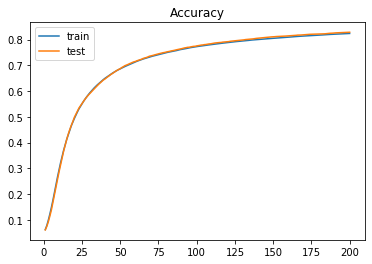

In [7]:
# plotLines(network.train_loss, network.test_loss, title="Loss", labels=["train", "test"])
plotLines(
    network_no_hidden.train_accuracy,
    network_no_hidden.test_accuracy,
    title="Accuracy",
    labels=["train", "test"],
)

In [8]:
predictYTrain = network_no_hidden.predict(trainX)
actualYTrain = np.argmax(trainY, axis=1)
print("TRAIN: F1 Score")
print(classification_report(predictYTrain, actualYTrain))

TRAIN: F1 Score
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5999
           1       0.93      0.92      0.93      6851
           2       0.81      0.82      0.81      5887
           3       0.80      0.80      0.80      6103
           4       0.83      0.84      0.84      5829
           5       0.69      0.73      0.71      5165
           6       0.89      0.89      0.89      5949
           7       0.83      0.85      0.84      6167
           8       0.74      0.72      0.73      6054
           9       0.77      0.77      0.77      5996

    accuracy                           0.82     60000
   macro avg       0.82      0.82      0.82     60000
weighted avg       0.82      0.82      0.82     60000



In [9]:
predictYTest = network_no_hidden.predict(testX)
actualYTest = np.argmax(testY, axis=1)
print("TEST: F1 Score")
print(classification_report(predictYTest, actualYTest))

TEST: F1 Score
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1010
           1       0.93      0.93      0.93      1129
           2       0.82      0.84      0.83      1003
           3       0.82      0.79      0.81      1053
           4       0.85      0.83      0.84      1008
           5       0.70      0.74      0.72       851
           6       0.89      0.88      0.88       970
           7       0.82      0.86      0.84       981
           8       0.73      0.73      0.73       980
           9       0.79      0.78      0.78      1015

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



### 3.3 Network with One Hidden Layer

In [16]:
network_one_hidden = Network(
    layers=[Dense(64), ReLU(), Dense(10), Softmax()],
    loss_function=MeanSquareErrorLoss(),
)

In [17]:
network_one_hidden.fit(X=trainX, y=trainY, testX=testX, testY=testY, epochs=200)

Network(
Layers: 
Dense ( Neurons: 64 )
ReLU()
Dense ( Neurons: 10 )
Softmax(), 
LossFunction: MeanSquareErrorLoss())

Accuracy at epoch 20:	0.7905
MSE Loss at epoch 20:	2276.742913323308
Accuracy at epoch 40:	0.8256
MSE Loss at epoch 40:	1825.7853532466584
Accuracy at epoch 60:	0.8388166666666667
MSE Loss at epoch 60:	1617.6135977712936
Accuracy at epoch 80:	0.8469833333333333
MSE Loss at epoch 80:	1484.5121301753968
Accuracy at epoch 100:	0.8532666666666666
MSE Loss at epoch 100:	1388.7290454908132
Accuracy at epoch 120:	0.8595166666666667
MSE Loss at epoch 120:	1307.1804670094518
Accuracy at epoch 140:	0.8635166666666667
MSE Loss at epoch 140:	1246.9499048106388
Accuracy at epoch 160:	0.8679
MSE Loss at epoch 160:	1199.6601123696742
Accuracy at epoch 180:	0.8716166666666667
MSE Loss at epoch 180:	1158.961977819669
Accuracy at epoch 200:	0.87445
MSE Loss at epoch 200:	1127.5665988072244


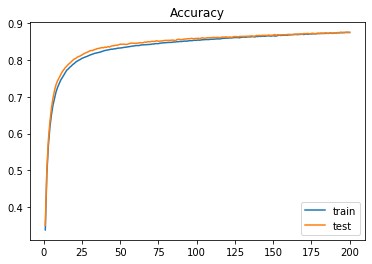

In [18]:
# plotLines(network.train_loss, network.test_loss, title="Loss", labels=["train", "test"])
plotLines(
    network_one_hidden.train_accuracy,
    network_one_hidden.test_accuracy,
    title="Accuracy",
    labels=["train", "test"],
)

In [19]:
predictYTrain = network_one_hidden.predict(trainX)
actualYTrain = np.argmax(trainY, axis=1)
print("TRAIN: F1 Score")
print(classification_report(predictYTrain, actualYTrain))

TRAIN: F1 Score
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5903
           1       0.97      0.95      0.96      6848
           2       0.86      0.87      0.87      5878
           3       0.83      0.82      0.83      6141
           4       0.89      0.86      0.87      6002
           5       0.81      0.79      0.80      5559
           6       0.91      0.92      0.91      5915
           7       0.91      0.90      0.90      6315
           8       0.79      0.82      0.80      5582
           9       0.83      0.84      0.83      5857

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



In [20]:
predictYTest = network_one_hidden.predict(testX)
actualYTest = np.argmax(testY, axis=1)
print("TEST: F1 Score")
print(classification_report(predictYTest, actualYTest))

TEST: F1 Score
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       992
           1       0.97      0.96      0.97      1151
           2       0.85      0.90      0.87       981
           3       0.86      0.83      0.84      1044
           4       0.89      0.86      0.88      1014
           5       0.81      0.79      0.80       914
           6       0.91      0.91      0.91       955
           7       0.88      0.91      0.89       995
           8       0.78      0.81      0.79       934
           9       0.85      0.84      0.85      1020

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



### 3.4 Comparing Both Networks

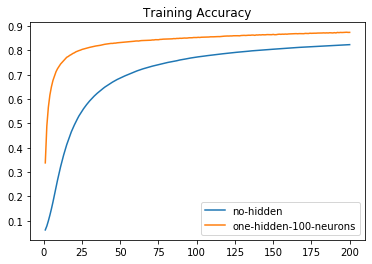

In [21]:
plotLines(
    network_no_hidden.train_accuracy,
    network_one_hidden.train_accuracy,
    title="Training Accuracy",
    labels=["no-hidden", "one-hidden-100-neurons"],
)